###### Inicialização

In [1]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 11.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
from itertools import product

from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
 
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

In [4]:
start_date = date(2012,1,1)
end_date = date(2022,12,31)
serie_dolar = pdr.get_data_yahoo("USDBRL=X", start=start_date, end=end_date).Close.asfreq('B').fillna(method="ffill")

[*********************100%***********************]  1 of 1 completed


# Análise de Séries temporais (Sessão 20)
---
Detecção de anomalias

Uma anomalia é o desvio em uma quantidade de seu valor esperado, por exemplo, a diferença entre uma medição e uma média ou uma previsão de modelo. – Wikipédia

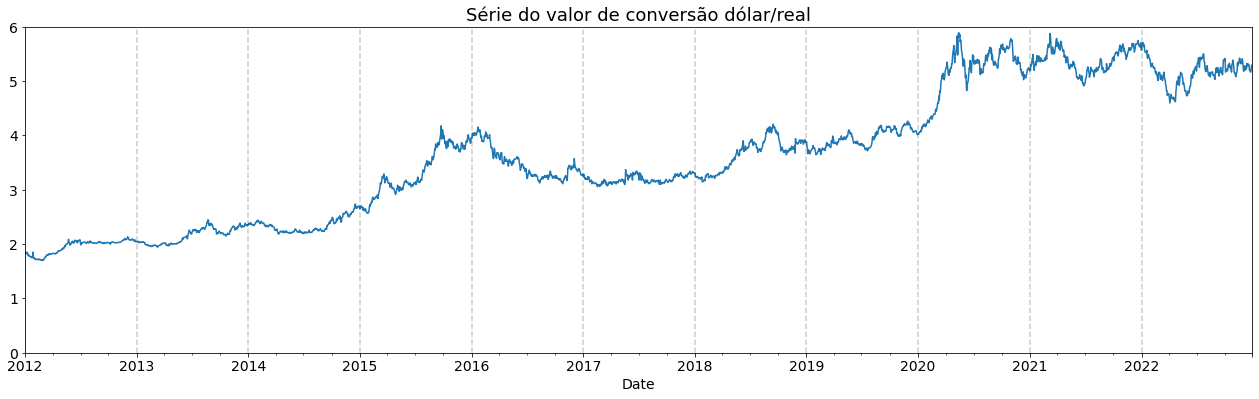

In [5]:
_ = serie_dolar.plot(title="Série do valor de conversão dólar/real", ylim=(0,6))

for year in range(start_date.year,end_date.year+2):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

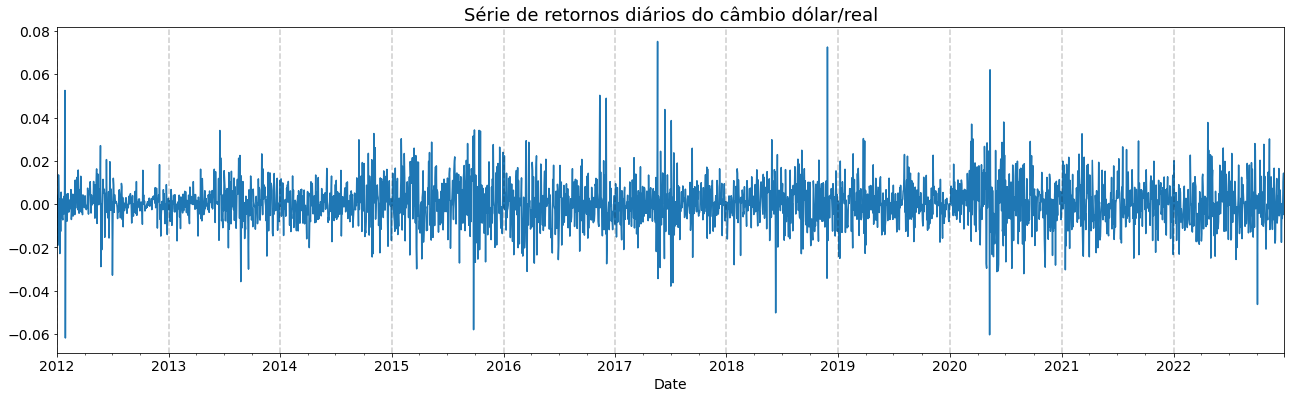

In [6]:
retornos_diarios = serie_dolar.pct_change().asfreq('B').fillna(0).rename("retornos")
retornos_diarios.plot(title = "Série de retornos diários do câmbio dólar/real")
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Técnica do Boxplot

<center>

![img](https://miro.medium.com/v2/resize:fit:640/format:webp/0*Zz3XmuErUXmIcy6C.png)

Fonte: [Outlier detection with Boxplots](https://medium.com/@agarwal.vishal819/outlier-detection-with-boxplots-1b6757fafa21)
</center>

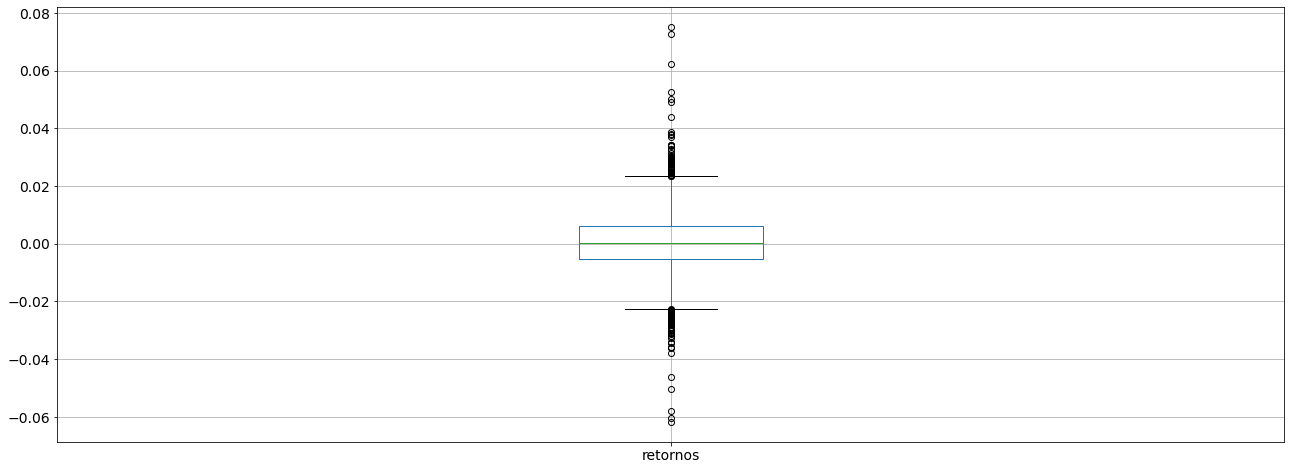

In [7]:
_ = retornos_diarios.to_frame().boxplot(figsize=(22,8))

In [12]:
q1 = retornos_diarios.quantile(0.25)
q3 = retornos_diarios.quantile(0.75)
iqr = q3 - q1
fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

In [13]:
anomalias_boxplot = retornos_diarios[(retornos_diarios < fence_low) | (retornos_diarios > fence_high)]

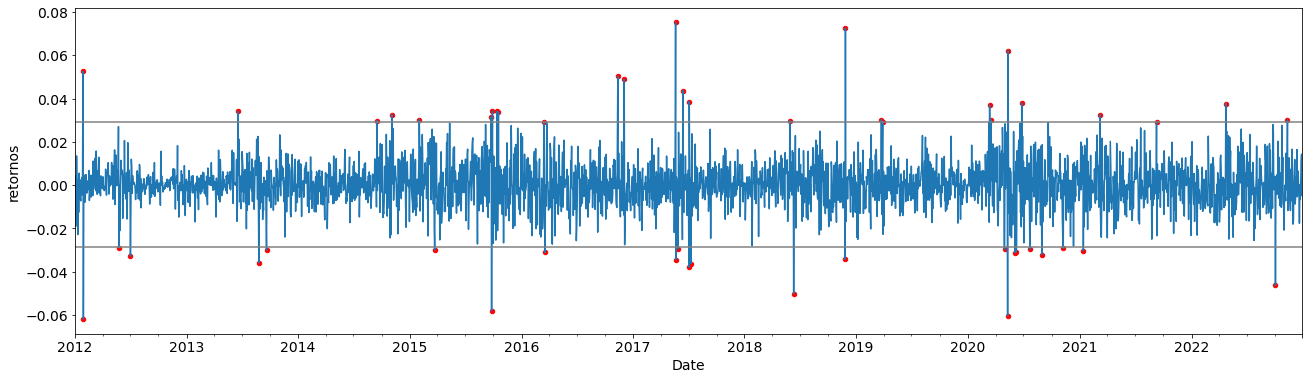

In [14]:
ax = retornos_diarios.plot(figsize = (22,6))
ax.axhline(y=fence_low, color="grey")
_ = ax.axhline(y=fence_high, color="grey")

_ = anomalias_boxplot.reset_index().plot(kind="scatter", style="o", color="r", ax=ax, y="retornos", x="Date")

In [15]:
retornos_diarios[(retornos_diarios < fence_low) | (retornos_diarios > fence_high)].count()

50

## Decomposição da série

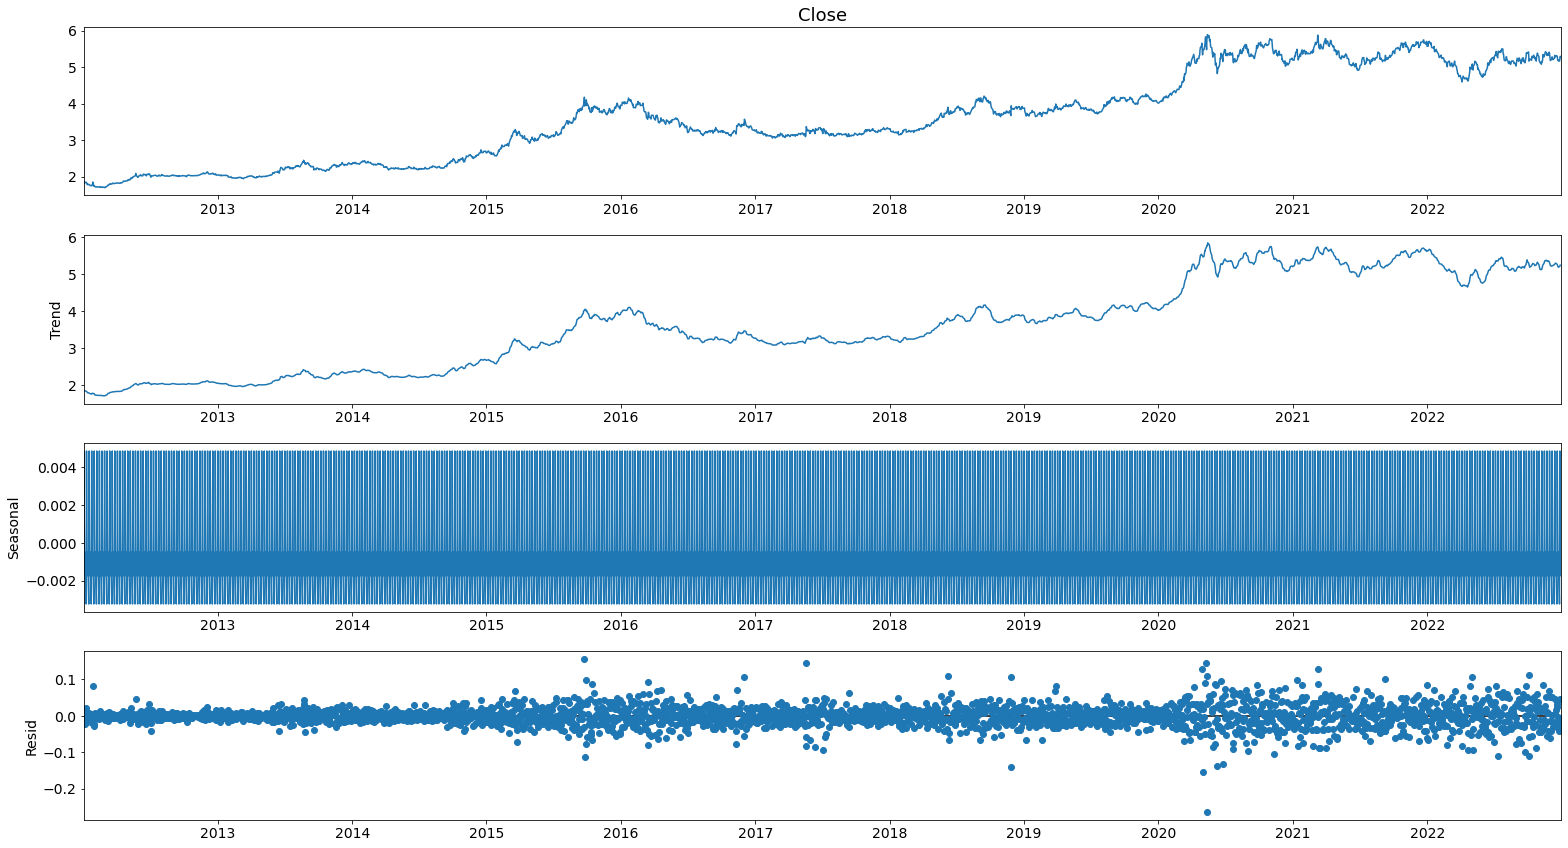

In [16]:
plt.rcParams["figure.figsize"] = (22,12)
result = sm.tsa.seasonal_decompose(serie_dolar, model='additive')
fig = result.plot()

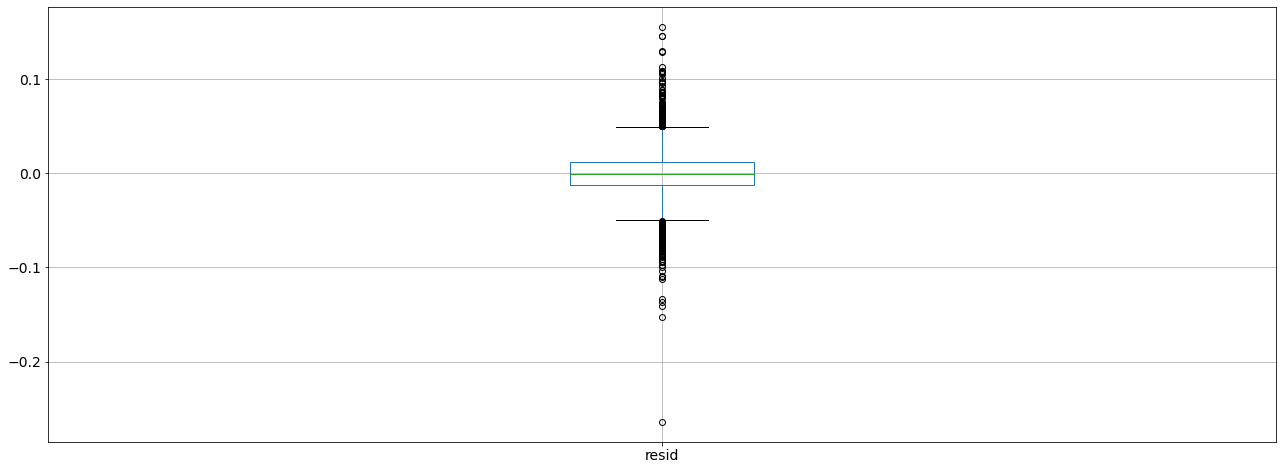

In [17]:
plt.rcParams["figure.figsize"] = (22,8)
residuos = pd.DataFrame(result.resid).dropna()
_ = residuos.boxplot()

In [18]:
q1 = residuos.quantile(0.25)[0]
q3 = residuos.quantile(0.75)[0]
iqr = q3 - q1
fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

In [19]:
anomalias = residuos[(residuos < fence_low) | (residuos > fence_high)]

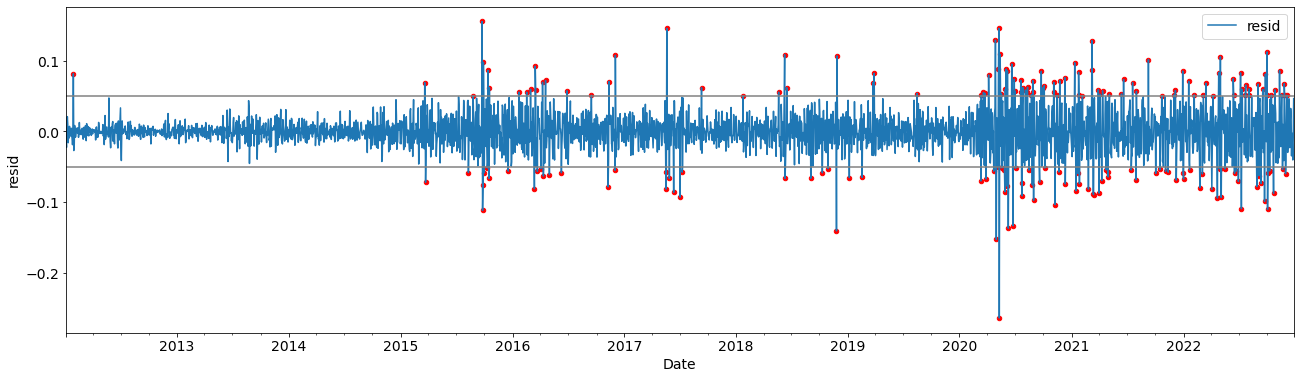

In [20]:
ax = residuos.plot(figsize = (22,6))
ax.axhline(y=fence_low, color="grey")
_ = ax.axhline(y=fence_high, color="grey")

_ = anomalias.reset_index().plot(kind="scatter", style="o", color="r", ax=ax, y="resid", x="Date")

In [21]:
residuos[(residuos < fence_low) | (residuos > fence_high)].count()

resid    200
dtype: int64

**Pros**

Os prós dessa abordagem estão em sua simplicidade e robustez. Ele pode lidar com muitas situações diferentes e todas as anomalias ainda podem ser interpretadas intuitivamente.

É bom principalmente para detectar outliers aditivos. Para detectar mudanças de nível, você pode analisar algum sinal médio móvel em vez do original.

**Contras**

Os contras dessa abordagem estão em sua rigidez em relação às opções de ajustes. Tudo o que você pode ajustar é seu intervalo de confiança usando o nível de significância.

O cenário típico em que não funciona bem é quando as características do seu sinal mudaram drasticamente. Por exemplo, você está rastreando usuários em seu site que foi fechado ao público e, de repente, foi aberto. Nesse caso, você deve rastrear as anomalias que ocorrem antes e depois dos períodos de inicialização separadamente.

## Árvores de Regressão e Classificação

In [ ]:
# scaler = StandardScaler()
# np_scaled = scaler.fit_transform(retornos_diarios.to_frame())
# data = pd.DataFrame(np_scaled)

In [22]:
retornos_diarios_df = retornos_diarios.rename("retornos").to_frame()

In [23]:
outliers_fraction = float(.01)
model =  IsolationForest(contamination=outliers_fraction)
model.fit(retornos_diarios_df)

IsolationForest(contamination=0.01)

In [24]:
retornos_diarios_df["anomalias"] = model.predict(retornos_diarios_df)

anomalias = retornos_diarios_df.loc[retornos_diarios_df['anomalias'] == -1]
anomalias.count()

retornos     29
anomalias    29
dtype: int64

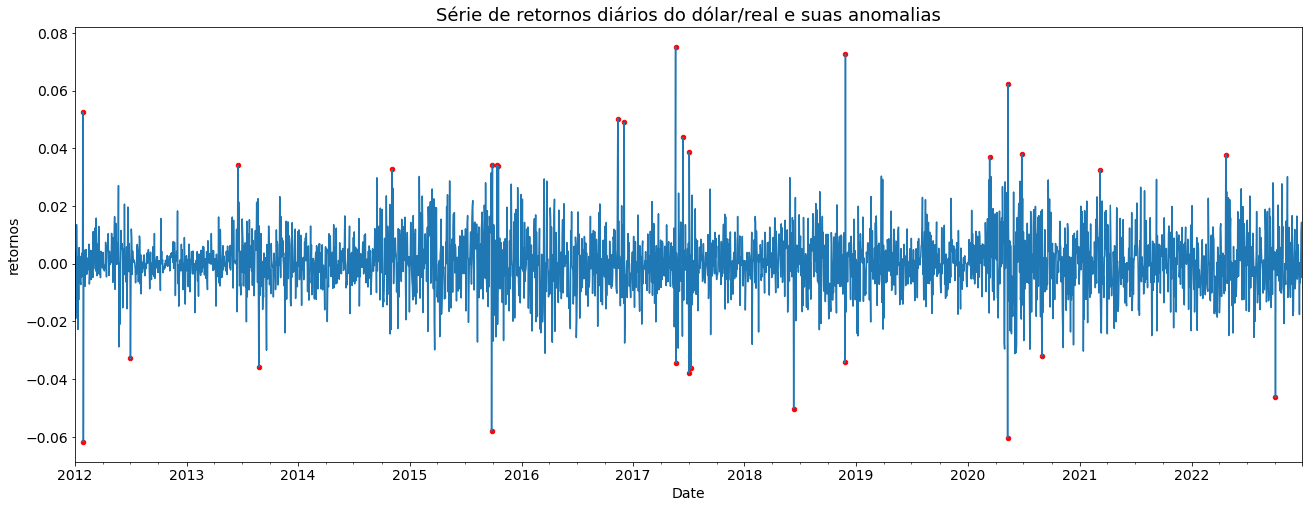

In [25]:
ax = retornos_diarios_df.retornos.plot(title="Série de retornos diários do dólar/real e suas anomalias")
_ = anomalias.reset_index().plot(kind="scatter", style="o", color="r", ax=ax, y="retornos", x="Date")

**Prós**

A força dessa abordagem é que ela não está vinculada de forma alguma à estrutura do seu sinal, e você pode introduzir muitos parâmetros de recursos para realizar o aprendizado e obter modelos sofisticados.

**Contras**

A fraqueza é que um número crescente de recursos pode começar a afetar seu desempenho computacional rapidamente. Nesse caso, você deve selecionar recursos conscientemente.

## Previsão de Modelos

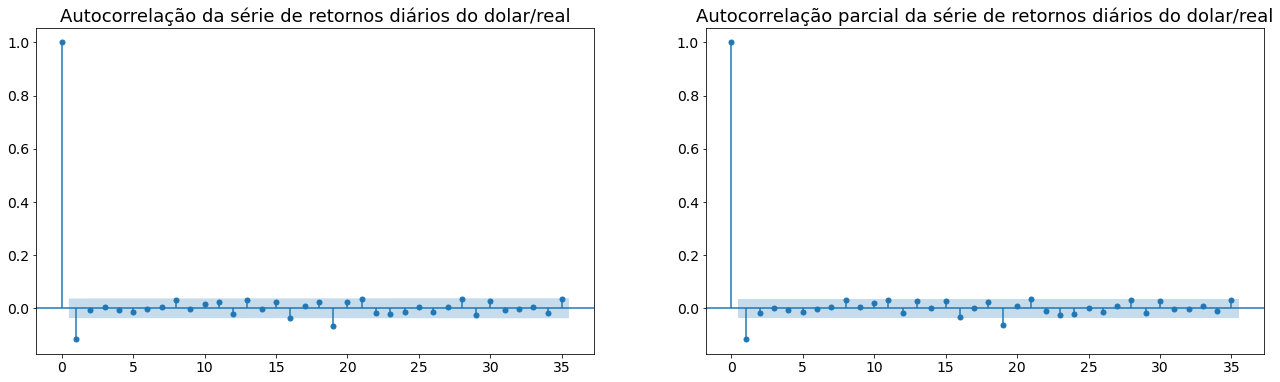

In [26]:
fig, axs = plt.subplots(1,2, figsize=(22,6))
tsa.plot_acf(retornos_diarios, ax = axs[0], title="Autocorrelação da série de retornos diários do dolar/real")
_ = tsa.plot_pacf(retornos_diarios, ax = axs[1], title="Autocorrelação parcial da série de retornos diários do dolar/real")

In [27]:
def find_anomalies(squared_errors, z=1):
    threshold = np.mean(squared_errors) + z * np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)

    return predictions, threshold

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Standard_deviation_diagram.svg/1200px-Standard_deviation_diagram.svg.png" height="300" />
</center>

In [28]:
arma = sm.tsa.arima.ARIMA(retornos_diarios, order=(1,0,1)).fit()
squared_errors = arma.resid ** 2

In [30]:
predictions, threshold = find_anomalies(squared_errors, z = 2)

anomalias_arima = retornos_diarios.loc[predictions == 1]
anomalias_arima.count()

85

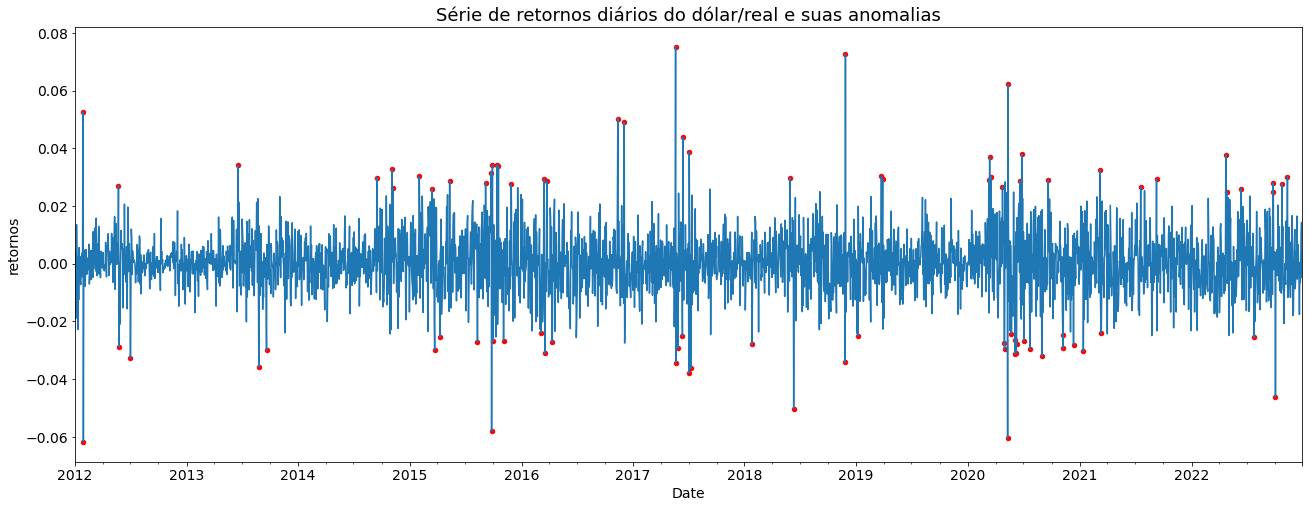

In [31]:
ax = retornos_diarios_df.retornos.plot(title="Série de retornos diários do dólar/real e suas anomalias")
_ = anomalias_arima.reset_index().plot(kind="scatter", style="o", color="r", ax=ax, y="retornos", x="Date")

## Modelos de Agrupamento

In [32]:
retornos_diarios_df["risco"] = retornos_diarios_df.retornos.rolling(21).std()
retornos_diarios_df = retornos_diarios_df.dropna()

<AxesSubplot:xlabel='retornos', ylabel='risco'>

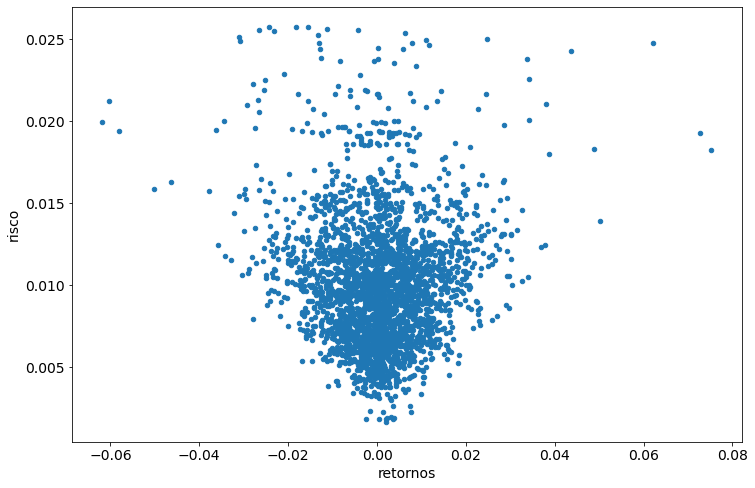

In [33]:
retornos_diarios_df.plot(kind="scatter", y="risco",x="retornos", figsize=(12,8))

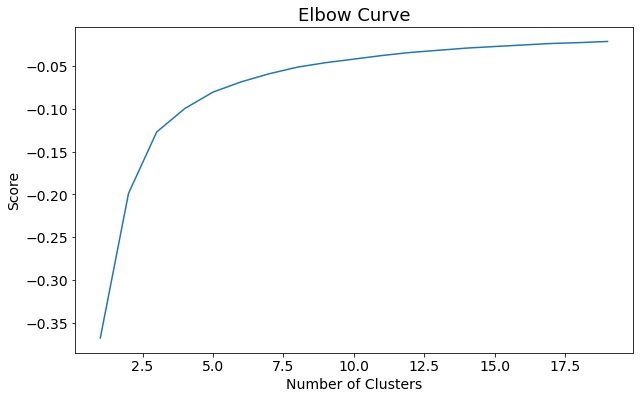

In [34]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(retornos_diarios_df[["risco","retornos"]]) for i in n_cluster]
scores = [kmeans[i].score(retornos_diarios_df[["risco","retornos"]]) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

In [35]:
X = retornos_diarios_df[["risco","retornos"]]
km = KMeans(n_clusters=5)
km.fit(X)
km.predict(X)
X["cluster"] = km.labels_
X["cluster"].value_counts()

2    1177
1     708
3     648
0     202
4     115
Name: cluster, dtype: int64

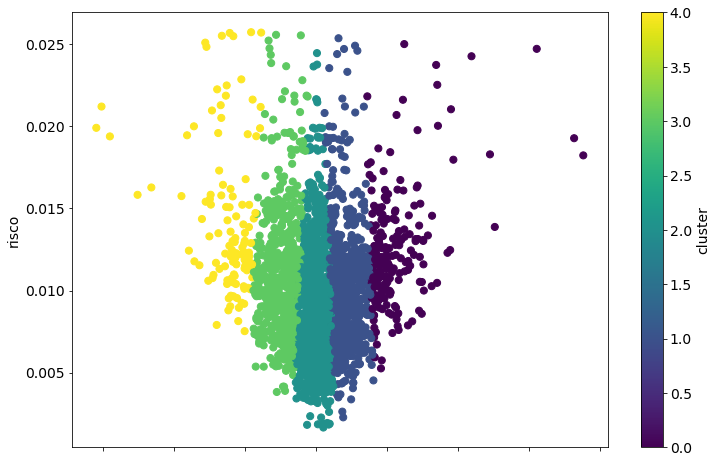

In [36]:
_ = X.plot(kind="scatter",y="risco",x="retornos",c="cluster", cmap="viridis", s=50, figsize=(12,8))

In [37]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series(index= data.index)
    for i in range(0,len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.iloc[i]=np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.02

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(X.retornos, km)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
X['anomalias'] = (distance >= threshold).astype(int)

In [38]:
X['anomalias'].sum()

57

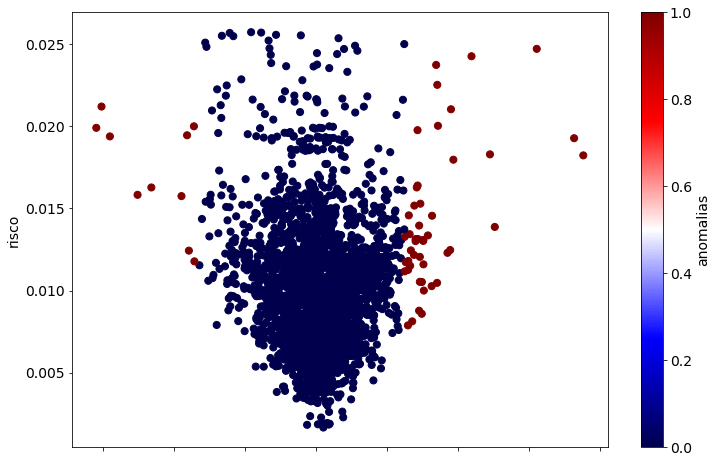

In [39]:
_ = X.plot(kind="scatter",y="risco",x="retornos",c="anomalias", cmap="seismic", s=50, figsize=(12,8))

In [40]:
anomalias_kmeans = X.loc[X.anomalias == 1]

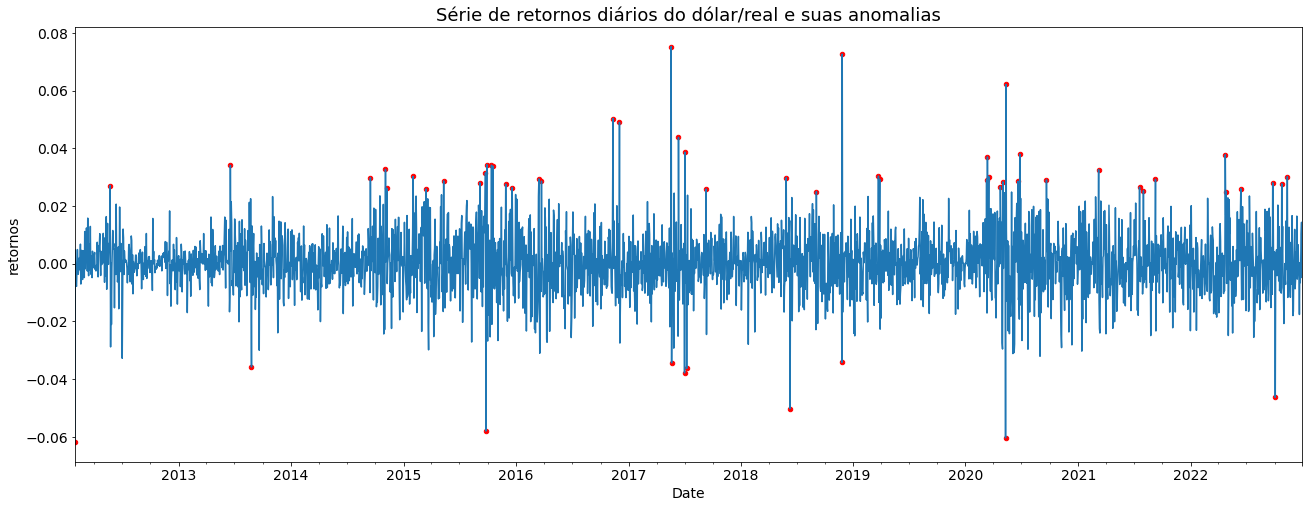

In [41]:
ax = X.retornos.plot(title="Série de retornos diários do dólar/real e suas anomalias")
_ = anomalias_kmeans.reset_index().plot(kind="scatter", style="o", color="r", ax=ax, y="retornos", x="Date")

## Exercício

1. Aplique todos os métodos para a série de temperatura média de sua cidade.
2. Aplique todos os métodos para a série de câmbio euro/dolar.

## Referências
- https://medium.com/@agarwal.vishal819/outlier-detection-with-boxplots-1b6757fafa21
- https://neptune.ai/blog/anomaly-detection-in-time-series
- https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py
- https://medium.com/bukalapak-data/time-series-anomaly-detection-simple-yet-powerful-approaches-4449ffe1ca12
- https://medium.com/mit-data-to-ai-lab/time-series-anomaly-detection-in-the-era-of-deep-learning-dccb2fb58fd